In [1]:
import pandas as pd
import numpy as np
from lifetimes import BetaGeoFitter, GammaGammaFitter

df = pd.read_csv(
    "../data/raw/online_retail.csv",
    encoding="ISO-8859-1"
)

df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df = df.dropna(subset=["Customer ID"])
df["TotalPrice"] = df["Quantity"] * df["Price"]

rfm = pd.read_csv("../data/processed/churn_dataset.csv", index_col="Customer ID")


In [3]:
from lifetimes.utils import summary_data_from_transaction_data

summary = summary_data_from_transaction_data(
    df,
    customer_id_col="Customer ID",
    datetime_col="InvoiceDate",
    monetary_value_col="TotalPrice",
    observation_period_end=df["InvoiceDate"].max()
)

summary.head()


,frequency,recency,T,monetary_value
Customer ID,,,,
12346.0,10.0,400.0,725.0,-15.468000
12347.0,7.0,402.0,404.0,717.398571
12348.0,4.0,363.0,438.0,449.310000
12349.0,4.0,717.0,735.0,1107.172500
12350.0,0.0,0.0,310.0,0.000000


In [4]:
bgf = BetaGeoFitter(penalizer_coef=0.01)
bgf.fit(
    summary["frequency"],
    summary["recency"],
    summary["T"]
)


<lifetimes.BetaGeoFitter: fitted with 5942 subjects, a: 0.08, alpha: 48.68, b: 0.73, r: 0.66>

In [7]:
summary[summary["monetary_value"] <= 0].head()


,frequency,recency,T,monetary_value
Customer ID,,,,
12346.0,10.0,400.0,725.0,-15.468
12350.0,0.0,0.0,310.0,0.000
12351.0,0.0,0.0,375.0,0.000
12354.0,0.0,0.0,232.0,0.000
12365.0,0.0,0.0,291.0,0.000


In [8]:
ggf_data = summary[
    (summary["monetary_value"] > 0) &
    (summary["frequency"] > 0)
]


In [9]:
ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(
    ggf_data["frequency"],
    ggf_data["monetary_value"]
)

<lifetimes.GammaGammaFitter: fitted with 4185 subjects, p: 3.77, q: 0.36, v: 3.69>

In [11]:
summary["clv_6m"] = ggf.customer_lifetime_value(
    bgf,
    summary["frequency"],
    summary["recency"],
    summary["T"],
    summary["monetary_value"].clip(lower=0.01),
    time=6,
    discount_rate=0.01
)


c:\Users\Sandeep Lohani\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [12]:
summary["clv_6m"].describe()


count      4915.000000
mean        833.367333
std        3600.182120
min          -4.447559
25%          63.601789
50%         278.389342
75%         781.497464
max      132046.783142
Name: clv_6m, dtype: float64

<Axes: >

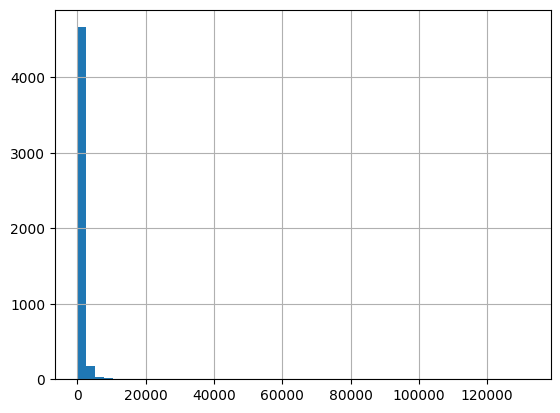

In [13]:
summary["clv_6m"].hist(bins=50)


### Gamma–Gamma Model Assumptions

The Gamma–Gamma model assumes strictly positive monetary values and repeat
purchase behavior. Customers with zero or negative monetary value are excluded
from model fitting but retained in downstream churn and segmentation analysis.


In [14]:
final_df = rfm.merge(
    summary[["clv_6m"]],
    left_index=True,
    right_index=True,
    how="left"
)

final_df["expected_loss"] = (
    final_df["clv_6m"] * final_df["churned"]
)

final_df.head()


,recency,frequency,monetary,R_score,F_score,M_score,RFM_score,segment,last_purchase_post,days_until_next_purchase,churned,clv_6m,expected_loss
Customer ID,,,,,,,,,,,,,
12346.0,295,17,-64.68,2,5,1,8,High Value - At Risk,NaN,NaN,1,0.255147,0.255147
12347.0,9,7,5408.50,5,4,5,14,High Value - Loyal,2011-12-07 15:52:00,28.0,0,2107.632229,0.000000
12348.0,44,5,2019.40,4,3,4,11,Mid Value - Stable,NaN,NaN,1,738.137648,738.137648
12349.0,377,4,2646.99,2,3,4,9,Mid Value - Stable,2011-11-21 09:51:00,11.0,0,1157.932782,0.000000
12350.0,279,1,334.40,2,1,2,5,Low Value - Likely Churn,NaN,NaN,1,NaN,NaN


In [15]:
def retention_action(row):
    if row["clv_6m"] > 500 and row["churned"] == 1:
        return "High Priority Retention"
    elif row["clv_6m"] > 500:
        return "Loyalty / Upsell"
    elif row["clv_6m"] < 100 and row["churned"] == 1:
        return "No Action"
    else:
        return "Low Cost Engagement"


In [16]:
final_df["retention_action"] = final_df.apply(retention_action, axis=1)
final_df["retention_action"].value_counts()


retention_action
Low Cost Engagement        2617
No Action                  1425
Loyalty / Upsell           1074
High Priority Retention     664
Name: count, dtype: int64

In [17]:
roi_summary = (
    final_df.groupby("retention_action")
    .agg(
        customers=("clv_6m", "count"),
        avg_clv=("clv_6m", "mean"),
        total_expected_loss=("expected_loss", "sum")
    )
)

roi_summary


,customers,avg_clv,total_expected_loss
retention_action,,,
High Priority Retention,664,1177.181612,781648.590534
Low Cost Engagement,1716,258.829156,321628.674956
Loyalty / Upsell,1074,2600.038374,0.000000
No Action,1425,22.418745,31946.711119


In [18]:
final_df.to_csv("../data/processed/final_retention_dataset.csv")
